In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane_snowflurry.utility.plotting_utils import graph
from pennylane_snowflurry.utility.debug_utility import SnowflurryUtility, arbitrary_circuit
from pennylane_snowflurry.transpiler.monarq_transpile import Transpiler
from pennylane_snowflurry.transpiler.transpiler_config import MonarqDefaultConfig

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
dev = qml.device("default.qubit", shots=1000)

def circuit(size : int):
    qml.Hadamard(0)
    for n in range(0, size - 1):
        qml.CNOT([n, n + 1])
    
    return qml.counts(wires=[i for i in range(size)])

In [5]:
def transpile_snowflurry(tape):
    snowflurryUtil = SnowflurryUtility(tape, 
                                       "https://manager.anyonlabs.com", 
                                       "stage", 
                                       "FjjIKjmDMoAMzSO4v2Bu62a+8vD39zib", 
                                       "calculqc")
    snowflurryUtil.transpile()
    return snowflurryUtil.to_pennylane()

def transpile_calculqc(tape, config):
    transpiler = Transpiler.get_transpiler(config)
    return transpiler(tape)[0][0]


In [ ]:
datas = {"snowflurry" : [], "calculqc" : []}

for i in range(3, 25):
    qnode = qml.QNode(lambda: circuit(i), dev)
    qnode()
    sf_tape = transpile_snowflurry(qnode.tape)
    cq_tape = transpile_calculqc(qnode.tape, MonarqDefaultConfig(use_benchmark=False))

    sf_node = qml.QNode(lambda : arbitrary_circuit(sf_tape, qml.counts), dev)
    cq_node = qml.QNode(lambda : arbitrary_circuit(cq_tape, qml.counts), dev)
    
    sf_resources = qml.specs(sf_node)()["resources"]
    cq_resources = qml.specs(cq_node)()["resources"]
    
    datas["snowflurry"].append(sf_resources.depth)
    datas["calculqc"].append(cq_resources.depth)

c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\gradients\gradient_transform.py:261: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


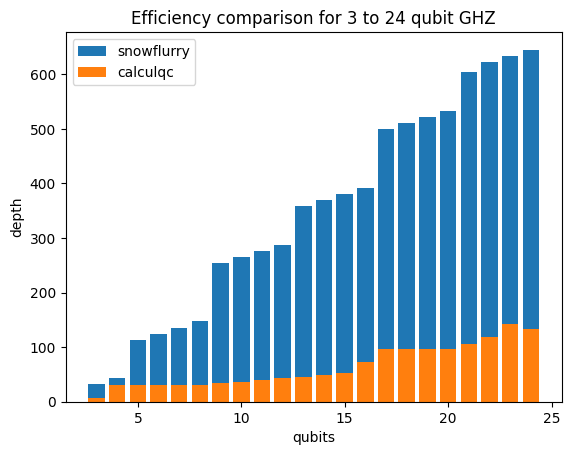

In [15]:
x_labels = np.arange(3, 25)

graph(plt.bar, datas, x_labels, "Efficiency comparison for 3 to 24 qubit GHZ", "qubits", "depth")